# Dự án thực hành
```
ProtonX - AI for devs
```

### Hướng dẫn làm bài
- Trong bài tập này bạn sẽ sử dụng Python 3.
- Sau khi bạn viết Code của mình xong, hãy chạy dòng Code đó để xem kết quả bên dưới.

### [Quan trọng] Chú ý
- **Không sử dụng hàm `input()` tại bất kỳ dòng lệnh nào**
- **Không thay đổi dòng code return của hàm**

Các bạn sẽ thực hiện `code` trong các phần hiển thị `#TODO: Lập trình tại đây` và thay thế các vị trí `None`. Có những câu hỏi chỉ cần trả về đáp án.

Sau khi viết xong Code của bạn, bạn hãy ấn "SHIFT"+"ENTER" để thực hiện chạy lệnh của Cell đó.

---
Điểm số:
* 10 điểm / Câu

Tiêu chí chấm điểm:
* Các bài tập sẽ được chấm dựa trên các Test-case.
* Các bạn không khởi tạo lại giá trị đầu vào bên trong hàm. Có thể khởi tạo các giá trị này ngoài hàm nhằm mục đích kiểm thử.

## Quan trọng: Dựa vào [notebook này](https://github.com/facebookresearch/segment-anything-2/blob/main/notebooks/automatic_mask_generator_example.ipynb) để chạy SAM với Flask:

### Cài đặt Ngrok

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything-2.git'

!mkdir -p images
!wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything-2/main/notebooks/images/cars.jpg

!mkdir -p ../checkpoints/
!wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt

PyTorch version: 2.4.1+cu121
Torchvision version: 0.19.1+cu121
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything-2.git to /tmp/pip-req-build-spuilse7
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything-2.git /tmp/pip-req-build-spuilse7
  Resolved https://github.com/facebookresearch/segment-anything-2.git to commit 7e1596c0b6462eb1d1ba7e1492430fed95023598
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
--2024-09-19 18:44:51--  https://raw.githubusercontent.com/facebookresearch/segment-anything-2/main/notebooks/images/cars.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1058188 (

In [3]:
!pip install flask pyngrok
!pip install flask-cors

In [4]:
from pyngrok import ngrok
from google.colab import userdata

# Replace 'YOUR_NGROK_AUTHTOKEN' with the authtoken you copied from the ngrok dashboard
authtoken = userdata.get("ngrok_key")
ngrok.set_auth_token(authtoken)


In [ ]:
!git clone https://github.com/facebookresearch/segment-anything-2.git

In [ ]:
%cd /content/segment-anything-2
!pip install -e .

In [ ]:
!wget https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt

In [5]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

In [6]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


### Tải model

In [7]:
image = Image.open('/content/stock-photo-welsh-corgi-pembroke.jpg')
image = np.array(image.convert("RGB"))

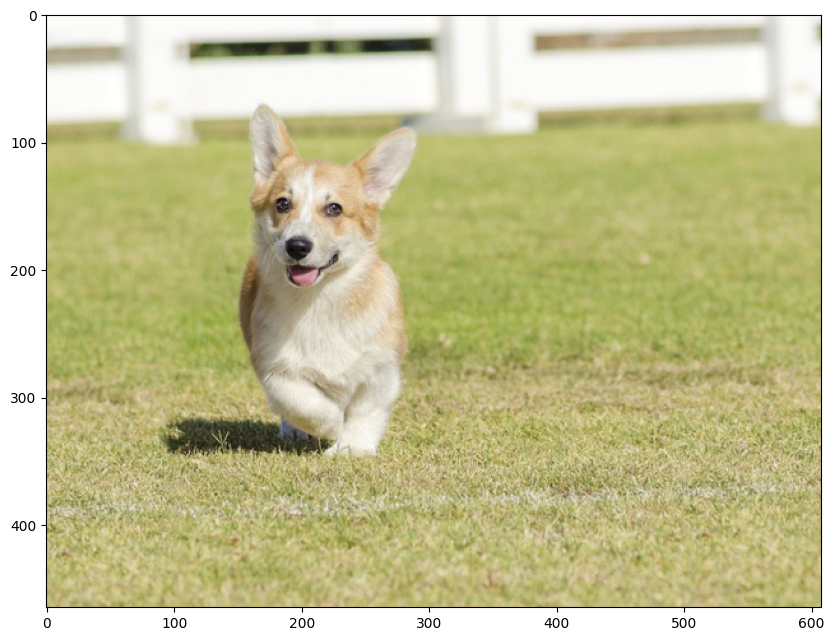

In [8]:

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('on')
plt.show()

link ảnh: https://www.google.com/url?sa=i&url=https%3A%2F%2Fcreate.vista.com%2Fphotos%2Fcorgi%2F&psig=AOvVaw1J6tZe4JgWD1KXPnthyQBg&ust=1726855541339000&source=images&cd=vfe&opi=89978449&ved=0CBQQjRxqFwoTCOikubTMz4gDFQAAAAAdAAAAABBY

Hàm hiện mask

In [9]:
np.random.seed(3)

def show_anns(anns, borders=True):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:, :, 3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask
        if borders:
            import cv2
            contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            # Try to smooth contours
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(img, contours, -1, (0, 0, 1, 0.4), thickness=1)

    ax.imshow(img)

In [10]:
image = Image.open('/content/stock-photo-welsh-corgi-pembroke.jpg')
image = np.array(image.convert("RGB"))

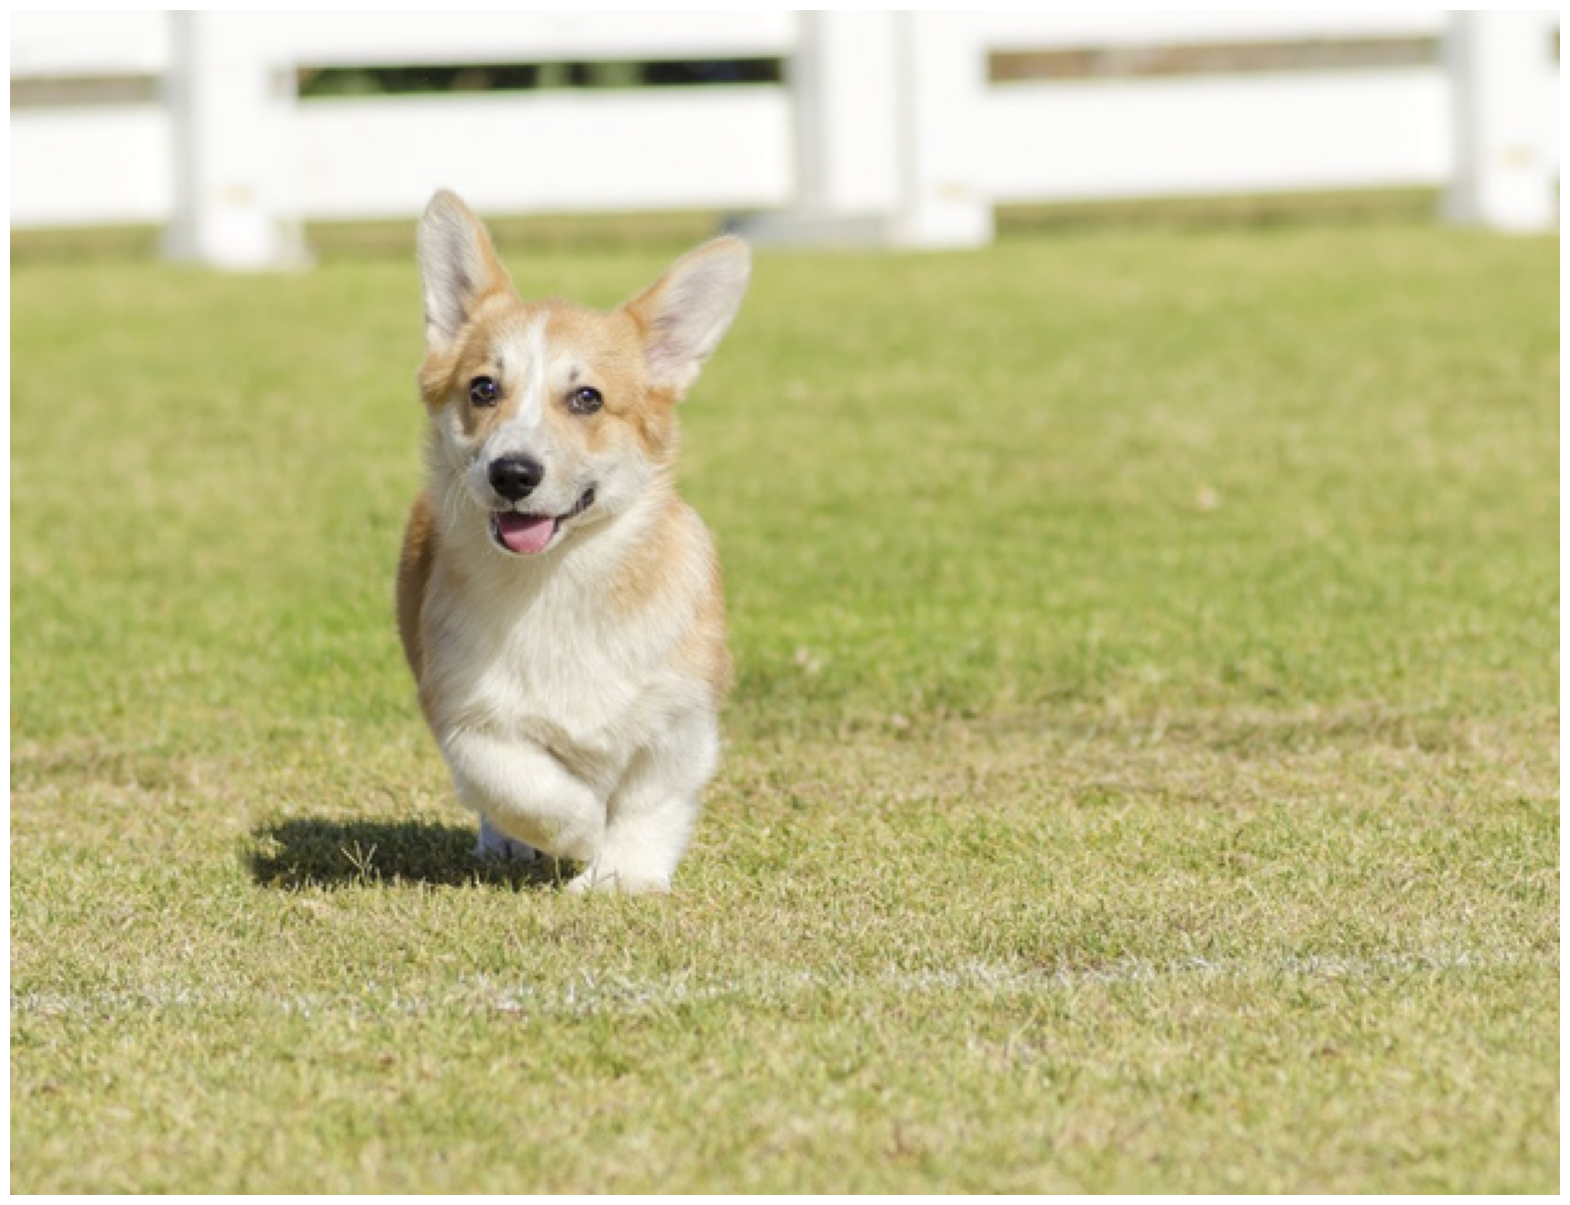

In [11]:
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

Solve error Cannot find primary config './sam2_hiera_l.yaml'. Check that it's in your config search path.
https://github.com/facebookresearch/segment-anything-2/issues/26

Chạy model

In [16]:
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

# TODO 1: Load model
sam2_checkpoint = "/content/segment-anything-2/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"
sam2 = build_sam2(model_cfg, sam2_checkpoint, device=device, apply_postprocessing=False)
mask_generator = SAM2AutomaticMaskGenerator(sam2)

# TODO 2: Run model trên ảnh
masks = mask_generator.generate(image)


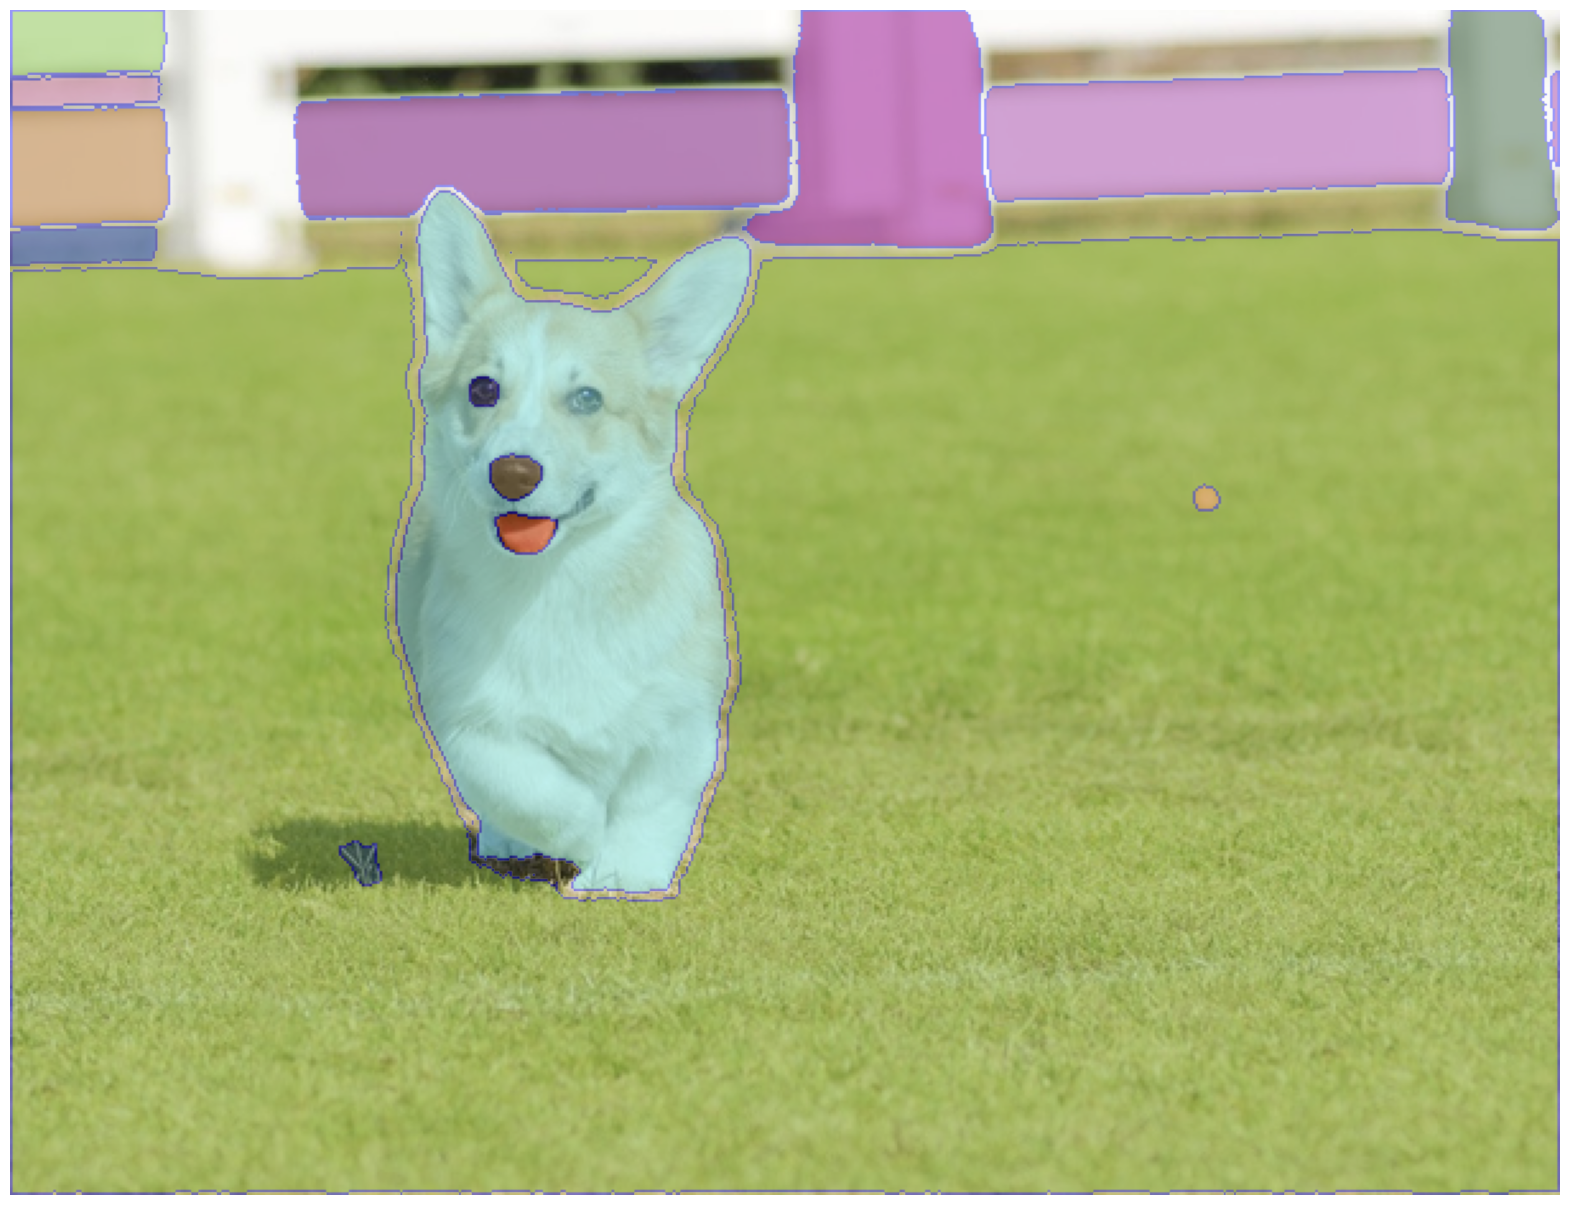

In [17]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

In [18]:
import numpy as np
import multiprocessing as mp
import time

def convert_chunk(chunk):
    return chunk.tolist()

def array_to_list_in_parallel(array, num_processes):
    # Determine the size of each chunk
    chunk_size = array.shape[0] // num_processes

    # Create chunks of the array
    chunks = [array[i*chunk_size:(i+1)*chunk_size] for i in range(num_processes)]

    # Use multiprocessing to convert each chunk to a list
    with mp.Pool(num_processes) as pool:
        result = pool.map(convert_chunk, chunks)

    # Combine the results into a single list
    list_representation = []
    for chunk_list in result:
        list_representation.extend(chunk_list)

    return list_representation


In [19]:
from flask import Flask, request, jsonify
from pyngrok import ngrok
from flask_cors import CORS
import cv2
import json

app = Flask(__name__)
CORS(app)  # Enable CORS

# Initialize your SAM generator (assuming it's done like this)
mask_generator = SAM2AutomaticMaskGenerator(sam2)

@app.route('/')
def home():
    return "Hello, World!"

@app.route('/sam2', methods=['POST'])
def sam_endpoint():
    # TODO 3: Nhận ảnh từ client
    # file = None
    # image = None
    file = request.files['image']
    image = cv2.imdecode(np.fromstring(file.read(), np.uint8), cv2.IMREAD_COLOR)


    # TODO 4: Chạy Inference trên ảnh
    # masks = None
    masks = mask_generator.generate(image)

    masks = sorted(masks, key=(lambda x: x['area']), reverse=True)

    masks = masks[:4]

    # Convert masks to a serializable format
    new_masks = []
    for item in masks:
        new_masks.append({
            "segmentation": array_to_list_in_parallel(item["segmentation"], mp.cpu_count()),
        })
    json_data = json.dumps(new_masks)

    return jsonify(json_data)

# Terminate any open tunnels if running in a reused environment
ngrok.kill()

# Create a tunnel to the default Flask port 5000
public_url = ngrok.connect(5000)
print(f"Public URL: {public_url}")

if __name__ == '__main__':
    app.run()


Public URL: NgrokTunnel: "https://2ed4-34-168-140-68.ngrok-free.app" -> "http://localhost:5000"
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [19/Sep/2024 18:50:35] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2024 18:50:35] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2024 18:50:46] "GET /sam2 HTTP/1.1" 405 -
<ipython-input-19-a82e93154211>:23: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  image = cv2.imdecode(np.fromstring(file.read(), np.uint8), cv2.IMREAD_COLOR)
INFO:werkzeug:127.0.0.1 - - [19/Sep/2024 18:53:31] "POST /sam2 HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2024 18:53:45] "POST /sam2 HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2024 19:03:25] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2024 19:03:33] "GET /data HTTP/1.1" 404 -
